In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from joblib import Parallel, delayed

In [3]:
from utils import load_config, perform_statistical_tests
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot
)

In [4]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df.head()

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05


### Detailed Low Level Features

In [8]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])

In [9]:
low_level_features   = pd.DataFrame(list(audio_processor.low_level_feature_generator(df.iloc[:5])))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


,audio_id,real_or_fake,f0,energy,speaking_rate_and_pauses
0,p225_002,R,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.002709378, 0.0040384317, 0.0044281585, 0.00...","{'speaking_rate': 123.19316688567675, 'pauses'..."
1,p225_002,F03,"[nan, nan, nan, 65.40639132514966, 65.40639132...","[0.0014545178, 0.0026531352, 0.00296167, 0.002...","{'speaking_rate': 123.0392156862745, 'pauses':..."
2,p225_002,F04,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.002566633, 0.0037462886, 0.004179004, 0.003...","{'speaking_rate': 123.19672131147541, 'pauses'..."
3,p225_002,F01,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.002960994, 0.005014162, 0.0052305344, 0.005...","{'speaking_rate': 122.85935255772843, 'pauses'..."
4,p225_002,F05,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0019256319, 0.002847619, 0.0031519828, 0.00...","{'speaking_rate': 123.07692307692308, 'pauses'..."


['f0', 'energy', 'speaking_rate_and_pauses']

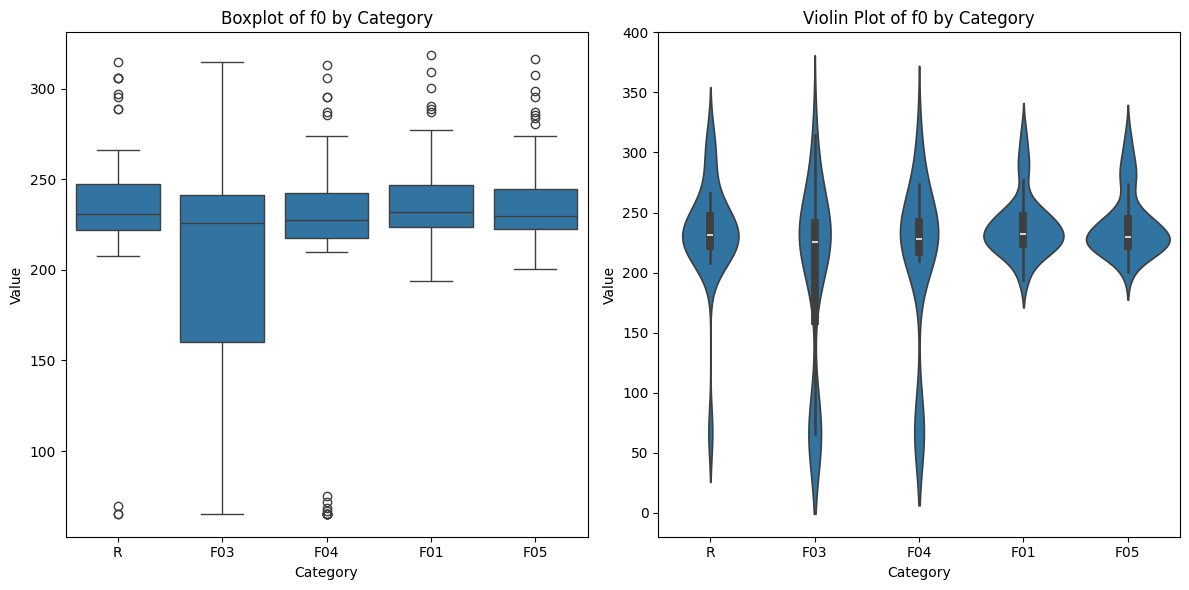

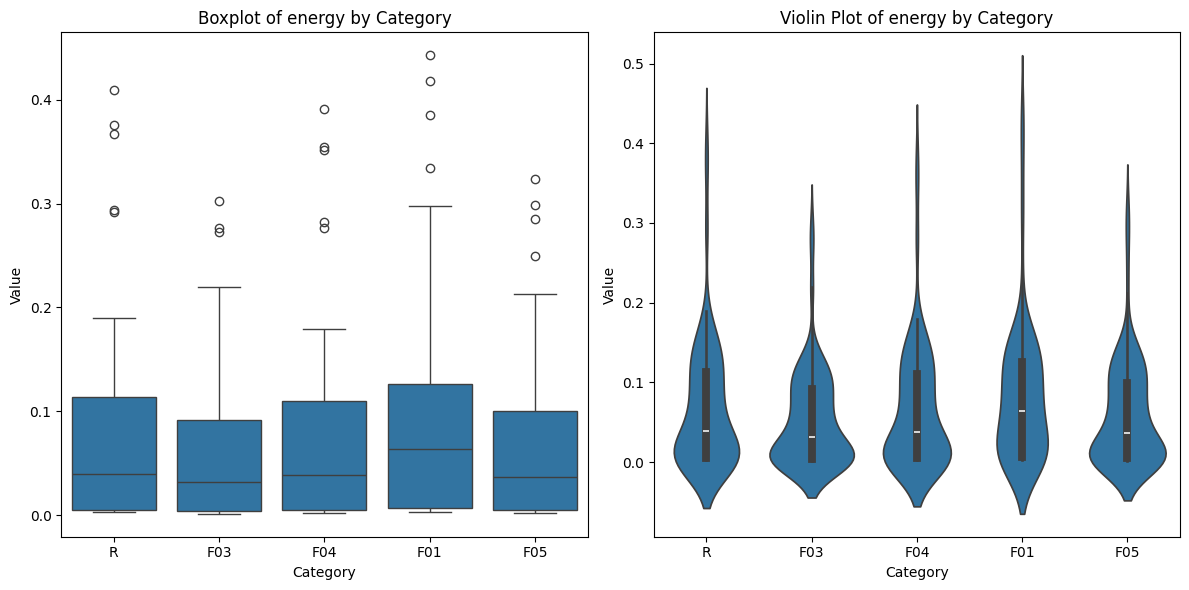

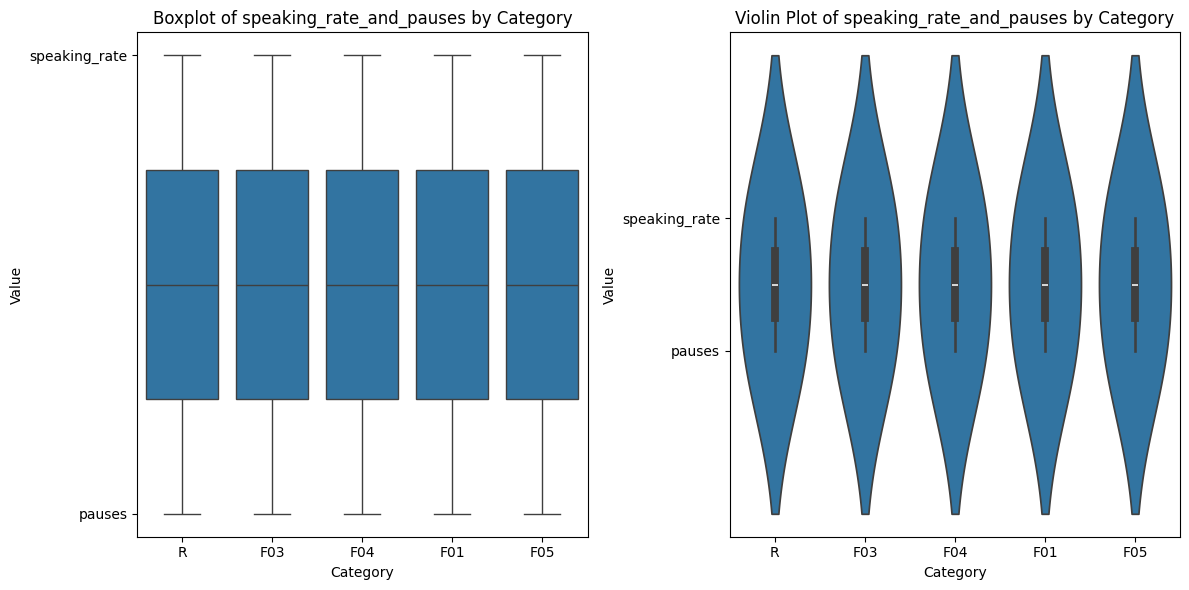

In [14]:
low_level_feature_df = pd.DataFrame(low_level_features)
for feature in [col for col in low_level_feature_df.columns if col not in ['audio_id', 'real_or_fake']]:
    plot_low_level_feature_dist(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [15]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [19]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])
feature_computer = HighLevelFeatureExtractor()

In [20]:
low_level_gen        = audio_processor.low_level_feature_generator(df.iloc[:2])
high_level_features  = list(feature_computer.high_level_feature_generator(low_level_gen))
high_level_features_df = pd.DataFrame(high_level_features)
high_level_features_df



Processing Audios:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Audios:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s]

Processing Audios: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


,audio_id,real_or_fake,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_range,f0_25th_percentile,f0_50th_percentile,...,energy_std,energy_var,energy_min,energy_max,energy_range,energy_25th_percentile,energy_50th_percentile,energy_75th_percentile,energy_skew,energy_kurtosis
0,p225_002,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.079021,0.006244,0.002709,0.409122,0.406412,0.005207,0.039705,0.113502,1.889479,4.605323
1,p225_002,F03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060147,0.003618,0.001455,0.302468,0.301014,0.003689,0.031681,0.091845,1.671517,3.544713


**Using Parallel Processing**

In [21]:
def extract_features(row, audio_processor, feature_computer):
    low_level_features = audio_processor.extract_features(row)
    high_level_features = feature_computer.compute_high_level_features(low_level_features)
    return high_level_features


In [26]:
audio_processor  = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])
feature_computer = HighLevelFeatureExtractor()

high_level_features   = Parallel(n_jobs=4)(delayed(extract_features)(row, audio_processor, feature_computer) for _, row in df.iloc[:70].iterrows())
high_level_feature_df = pd.DataFrame(high_level_features)
high_level_feature_df

,audio_id,real_or_fake,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_range,f0_25th_percentile,f0_50th_percentile,...,energy_std,energy_var,energy_min,energy_max,energy_range,energy_25th_percentile,energy_50th_percentile,energy_75th_percentile,energy_skew,energy_kurtosis
0,p225_002,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.079021,0.006244,0.002709,0.409122,0.406412,0.005207,0.039705,0.113502,1.889479,4.605323
1,p225_002,F03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060147,0.003618,0.001455,0.302468,0.301014,0.003689,0.031681,0.091845,1.671517,3.544713
2,p225_002,F04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076151,0.005799,0.002567,0.390661,0.388095,0.004697,0.038407,0.110402,1.802160,4.169264
3,p225_002,F01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.085765,0.007356,0.002961,0.442662,0.439701,0.006948,0.064026,0.126028,1.936061,4.941773
4,p225_002,F05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.065314,0.004266,0.001926,0.323629,0.321704,0.005115,0.036805,0.099917,1.556688,2.994649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,p225_014,F04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061121,0.003736,0.001725,0.252362,0.250637,0.003509,0.015703,0.094716,1.000177,0.039767
66,p225_014,F01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.063733,0.004062,0.001852,0.286604,0.284752,0.003818,0.033899,0.102399,1.009073,0.485060
67,p225_014,F05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.055251,0.003053,0.001798,0.215718,0.213920,0.003556,0.016621,0.092888,0.918075,-0.246433
68,p225_014,F02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.061995,0.003843,0.001553,0.236003,0.234451,0.003683,0.015341,0.100840,0.997938,-0.094269


In [28]:
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
0,energy_mean,0.031932,0.974990,315.0,0.807708,0.010221,0.000796,0.977579
1,energy_std,0.243906,0.811101,333.0,0.585399,0.080009,0.050807,0.822341
2,energy_var,0.145095,0.886790,333.0,0.585399,0.046782,0.016867,0.897050
3,energy_min,1.412094,0.175505,411.0,0.063631,0.403078,1.062688,0.306256
4,energy_max,0.305422,0.765674,308.0,0.899820,0.111107,0.122789,0.727113
5,energy_range,0.299708,0.769917,307.0,0.913121,0.109055,0.118374,0.731867
6,energy_25th_percentile,-0.241181,0.812099,324.0,0.693249,-0.067628,0.029350,0.864482
7,energy_50th_percentile,-0.158160,0.876952,292.0,0.899820,-0.054479,0.025892,0.872640
8,energy_75th_percentile,0.025502,0.980024,320.0,0.743434,0.008156,0.000506,0.982119
9,energy_skew,0.299563,0.769915,315.0,0.807708,0.107361,0.110257,0.740873


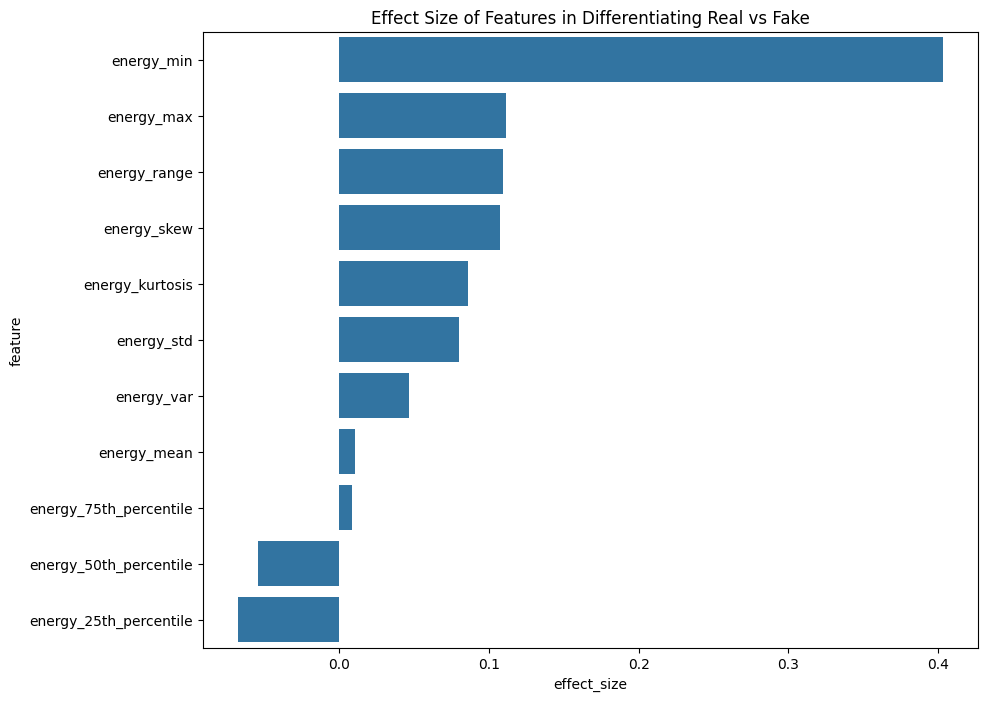

In [32]:
# Visualize the results
plt.figure(figsize=(10, 8))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

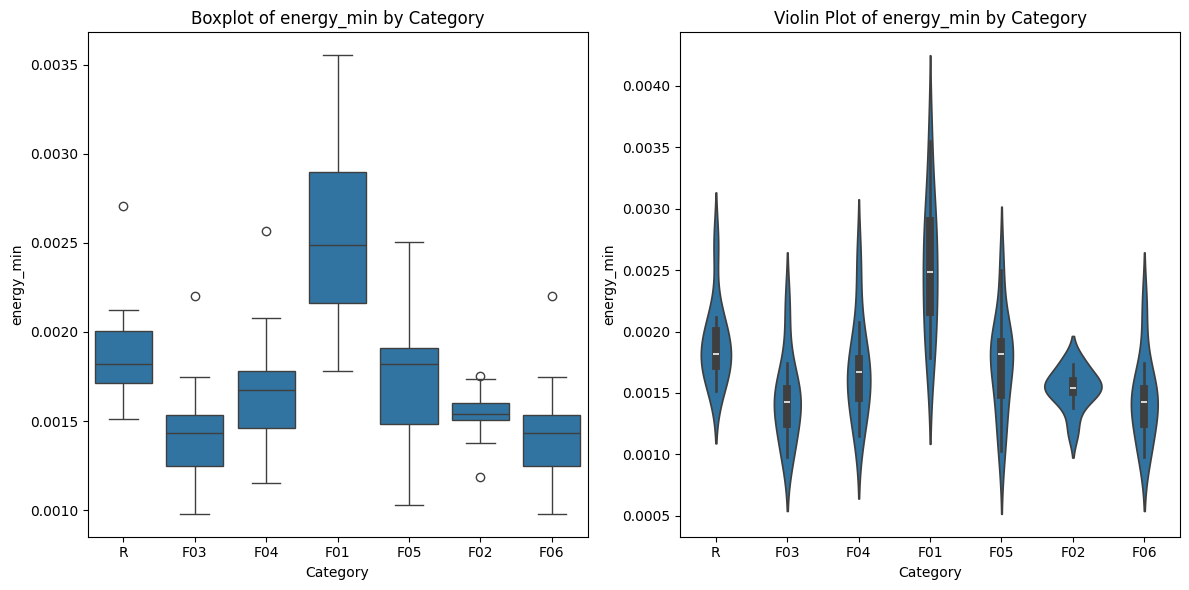

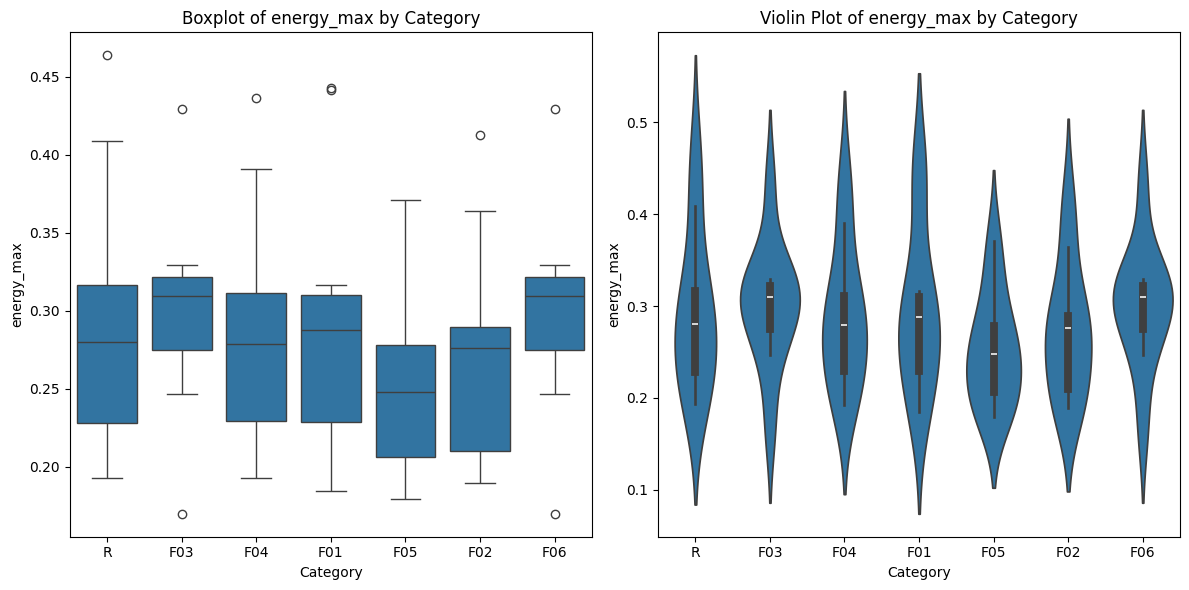

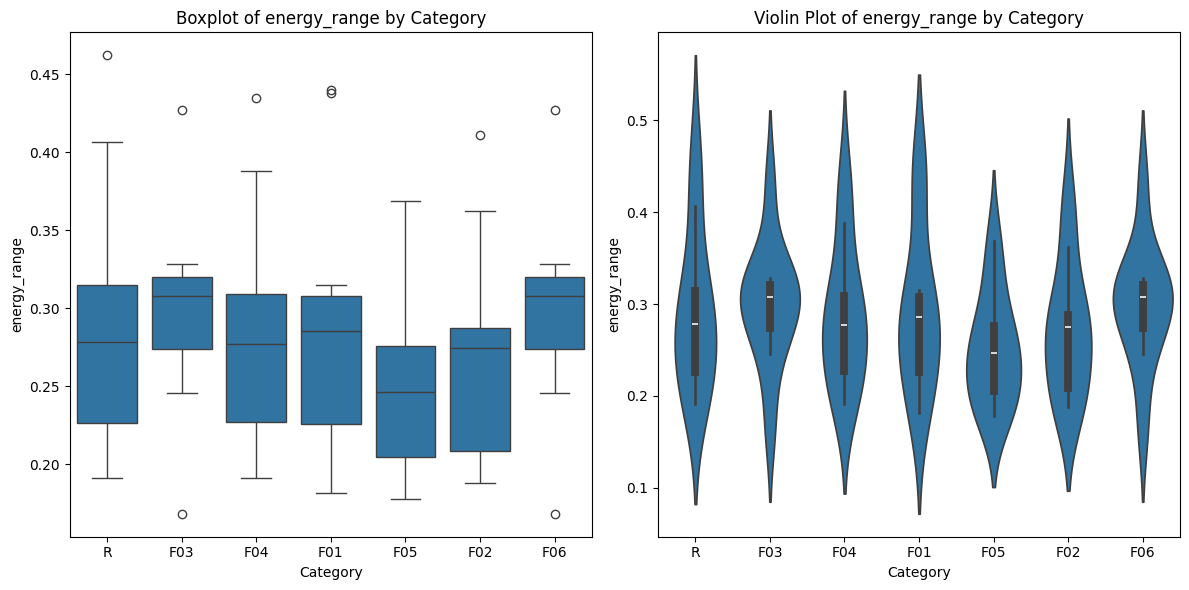

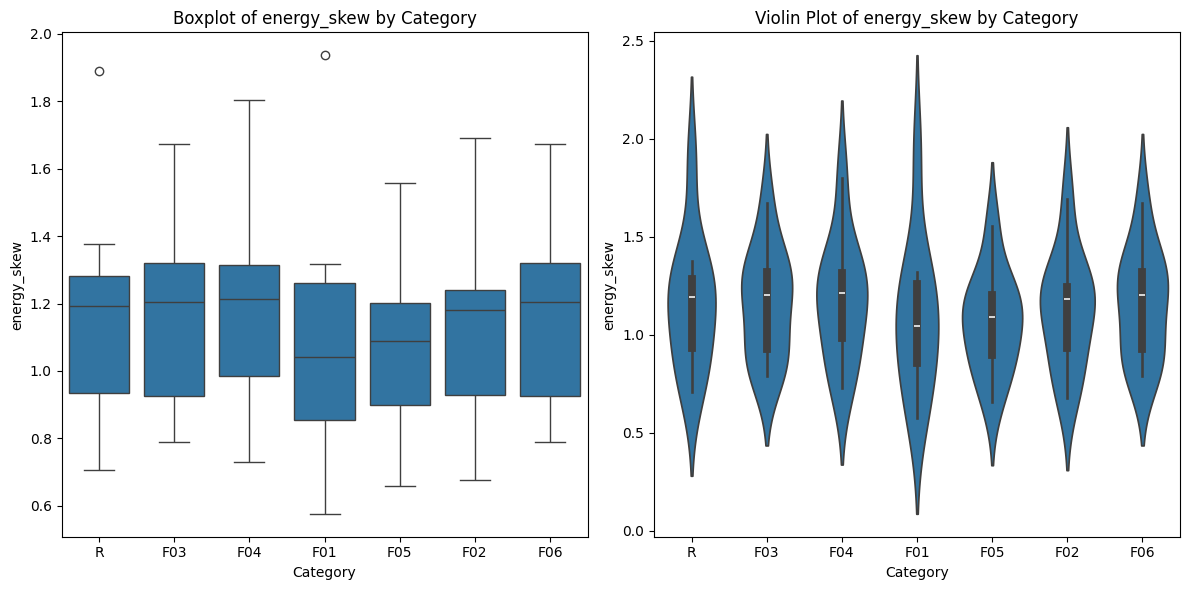

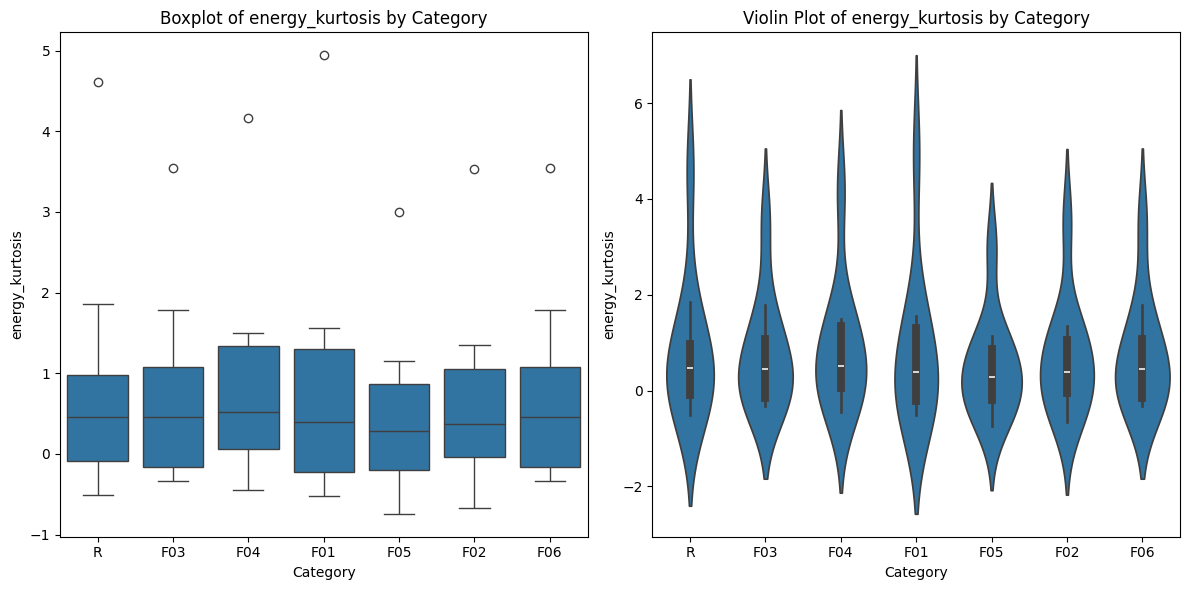

In [33]:
all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_high_level_feature_dist(high_level_feature_df, all_features[:5])

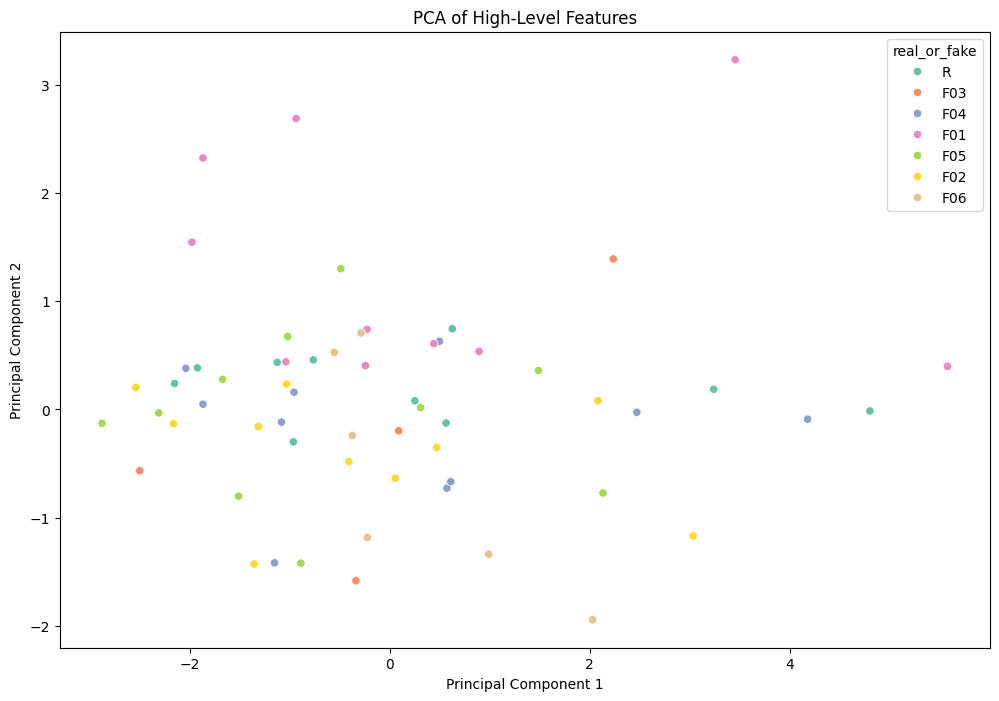

In [36]:
perform_pca_and_plot(high_level_feature_df, all_features[:5])

In [37]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    # Drop columns with NaN values
    df_clean = df.dropna(axis=1)
    
    # Ensure selected features are in the cleaned DataFrame
    selected_features = [feature for feature in selected_features if feature in df_clean.columns]

    X = df_clean[selected_features]
    y = df_clean[target_column].apply(lambda x: 1 if x == 'R' else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    feature_importances = model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

,feature,importance
0,energy_min,0.484323
1,energy_max,0.277255
2,energy_range,0.274489
9,energy_50th_percentile,0.060282
5,energy_std,0.038915
7,energy_mean,-0.114678
3,energy_skew,-0.128127
4,energy_kurtosis,-0.159352
8,energy_75th_percentile,-0.191184
6,energy_var,-0.211431


### Redundant Features

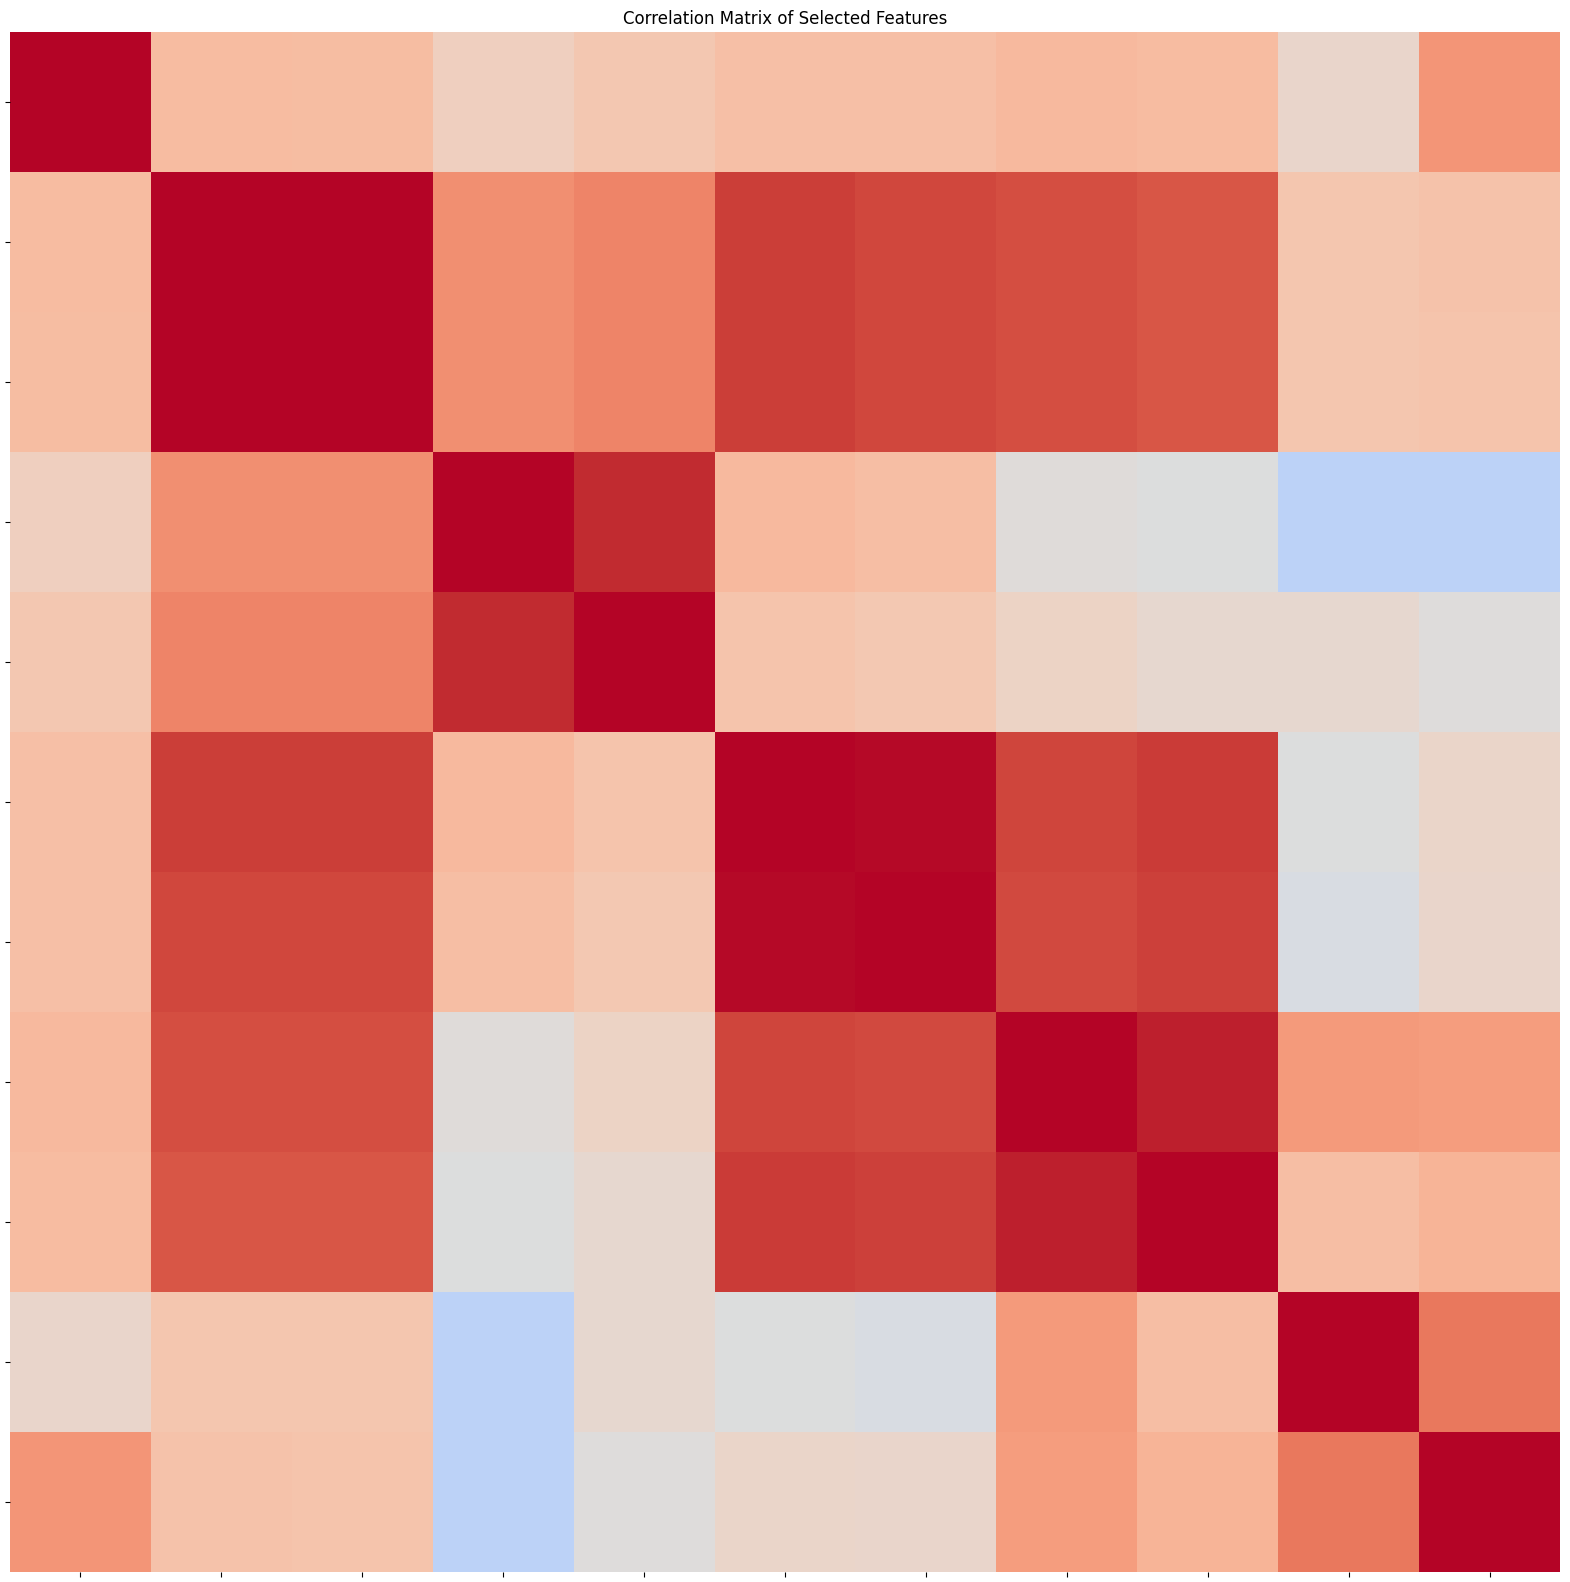

In [38]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [39]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['energy_min', 'energy_max', 'energy_skew', 'energy_50th_percentile']


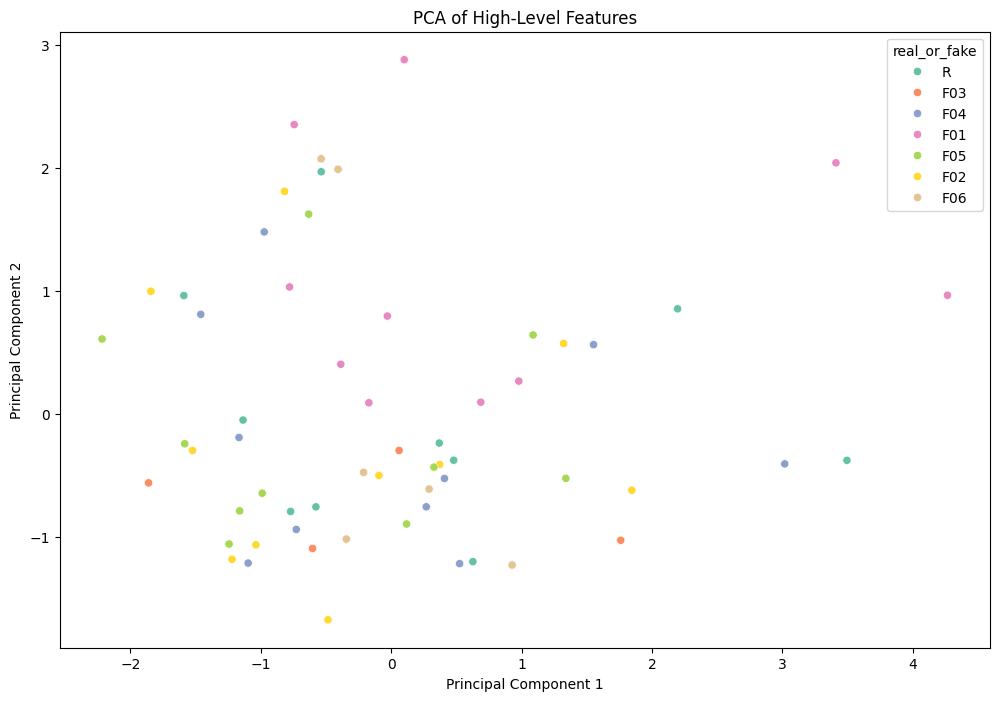

In [40]:
perform_pca_and_plot(high_level_feature_df, reduced_features)

In [41]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features[:2])
importance_df

,feature,importance
0,energy_min,0.28476
1,energy_max,0.01614


### Baseline Model

In [43]:
good_features = reduced_features

In [44]:
X = high_level_feature_df[good_features]
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


Model: Logistic Regression
Accuracy: 0.9286
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      1.00      0.96        13
        Real       0.00      0.00      0.00         1

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8571
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

        Fake       0.92      0.92      0.92        13
        Real       0.00      0.00      0.00         1

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14

-------------------------------------------------------

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_clas